In [34]:
import numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST, ImageFolder, DatasetFolder
import matplotlib.pyplot as plt

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

In [35]:
# Transformation en tenseur :
t = transforms.Compose([transforms.Grayscale(), transforms.ToTensor(),])

train_dataset = ImageFolder('/home/ysteux/nosave/PPC/Train/', transform = t)
test_dataset = ImageFolder('/home/ysteux/nosave/PPC/Test/', transform = t)

print("Training data:", train_dataset)
print("\nTest data:", test_dataset)
# Create DataLoader
# Dataloader train
dataloader_args = dict(shuffle=True, batch_size=100,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=100)
train_loader = dataloader.DataLoader(train_dataset, **dataloader_args)

# Dataloader test
dataloader_args = dict(shuffle=True, batch_size=len(test_dataset),num_workers=4, pin_memory=True)
test_loader = dataloader.DataLoader(test_dataset, **dataloader_args)

Training data: Dataset ImageFolder
    Number of datapoints: 135
    Root Location: /home/ysteux/nosave/PPC/Train/
    Transforms (if any): Compose(
                             Grayscale(num_output_channels=1)
                             ToTensor()
                         )
    Target Transforms (if any): None

Test data: Dataset ImageFolder
    Number of datapoints: 67
    Root Location: /home/ysteux/nosave/PPC/Test/
    Transforms (if any): Compose(
                             Grayscale(num_output_channels=1)
                             ToTensor()
                         )
    Target Transforms (if any): None


In [36]:
# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(1024, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view((-1, 1024))
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h, dim=0)    
    
    
model = Model()
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [40]:
EPOCHS = 100
losses = []

# Eval
data_iter = iter(train_loader)
evaluate_x, evaluate_y = data_iter.next()

if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()
train_size = len(train_loader.dataset)
batch_size = (train_size / 20) if (cuda) else  (train_size / 20)

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

         
        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                train_size,
                100. * batch_idx / batch_size, 
                loss.cpu().item()), 
                end='')

    # display final evaluation for this epoch
    model.eval()
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().item()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        train_size, 
        train_size,
        100. * batch_idx / batch_size, 
        loss.cpu().item(),
        accuracy*100,
        end=''))

 Train Epoch: 1/100 [135/135 (15%)]	Loss: 0.622875	 Test Accuracy: 78.0000%
 Train Epoch: 2/100 [135/135 (15%)]	Loss: 0.838029	 Test Accuracy: 74.0000%
 Train Epoch: 3/100 [135/135 (15%)]	Loss: 0.850157	 Test Accuracy: 82.0000%
 Train Epoch: 4/100 [135/135 (15%)]	Loss: 0.687924	 Test Accuracy: 78.0000%
 Train Epoch: 5/100 [135/135 (15%)]	Loss: 0.661904	 Test Accuracy: 83.0000%
 Train Epoch: 6/100 [135/135 (15%)]	Loss: 0.613106	 Test Accuracy: 81.0000%
 Train Epoch: 7/100 [135/135 (15%)]	Loss: 0.633554	 Test Accuracy: 83.0000%
 Train Epoch: 8/100 [135/135 (15%)]	Loss: 0.565757	 Test Accuracy: 75.0000%
 Train Epoch: 9/100 [135/135 (15%)]	Loss: 0.686636	 Test Accuracy: 84.0000%
 Train Epoch: 10/100 [135/135 (15%)]	Loss: 0.820574	 Test Accuracy: 83.0000%
 Train Epoch: 11/100 [135/135 (15%)]	Loss: 0.735896	 Test Accuracy: 82.0000%
 Train Epoch: 12/100 [135/135 (15%)]	Loss: 0.560298	 Test Accuracy: 83.0000%
 Train Epoch: 13/100 [135/135 (15%)]	Loss: 0.480490	 Test Accuracy: 88.0000%
 Train E

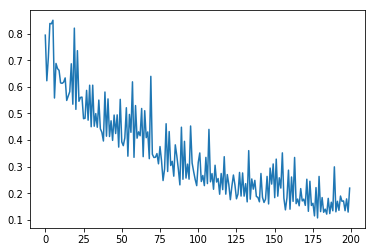

In [41]:
# Evolution des résultats de la fonction "loss" :
plt.plot(losses)

In [42]:
model.eval()
output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().item()/d.size()[0]
print('Accuracy:', accuracy*100, '%')

Accuracy: 97.0 %
